In [20]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from isyatirimhisse import StockData, Financials

In [1084]:
financials = Financials()
df = financials.get_data(
    symbols='TAVHL',
    start_year='2010',
    save_to_excel=True
)


Data saved to financials_20240830


In [1085]:
bilanco=pd.read_excel("financials_20240830.xlsx")

In [1087]:
q1=bilanco[bilanco["itemDescTr"]=="Satış Gelirleri"].iloc[:,3:].T[::4]
satışlar=bilanco[bilanco["itemDescTr"]=="Satış Gelirleri"].iloc[:,3:].T


In [1088]:
current_liabilities=bilanco[bilanco['itemDescTr'].str.contains('yükümlülük', case=False, na=False)].iloc[:4,3:].sum(axis=0)
total_liabilities=bilanco[bilanco['itemDescTr'].str.contains('yükümlülük', case=False, na=False)].iloc[:,3:].sum(axis=0)

In [1089]:
current_assets = bilanco.loc[bilanco['itemDescEng'] == 'CURRENT ASSETS'].values[0][3:]
total_assets = bilanco.loc[bilanco['itemDescEng'] == 'TOTAL ASSETS'].values[0][3:]
shareholders_equity = bilanco.loc[bilanco['itemDescEng'] == 'SHAREHOLDERS EQUITY'].values[0][3:]
net_profit_after_taxes = bilanco.loc[bilanco['itemDescEng'] == 'NET PROFIT AFTER TAXES'].values[0][3:]
domestic_sales = bilanco.loc[bilanco['itemDescEng'] == 'Domestic Sales'].values[0][3:]
export_sales = bilanco.loc[bilanco['itemDescEng'] == 'Export Sales'].values[0][3:]
netkar=bilanco.loc[bilanco['itemDescTr'] == 'Dönem Net Kar/Zararı'].values[0][3:]
özkaynaklar=bilanco.loc[bilanco['itemDescTr'] == 'Özkaynaklar'].values[0][3:]
satışlar=bilanco.loc[bilanco['itemDescTr'] == 'Satış Gelirleri'].values[0][3:]
brütkar=bilanco.loc[bilanco['itemDescTr'] == 'BRÜT KAR (ZARAR)'].values[0][3:]
faaliyetkarı=bilanco.loc[bilanco['itemDescTr'] == 'FAALİYET KARI (ZARARI)'].values[0][3:]
# Calculate the ratios
current_ratio = current_assets / current_liabilities
debt_to_equity_ratio = total_liabilities / shareholders_equity
return_on_equity = net_profit_after_taxes / shareholders_equity
net_profit_margin = net_profit_after_taxes / satışlar
roe=netkar/özkaynaklar
asset_turnover=satışlar/total_assets
brütkarmarjı=brütkar/satışlar
faaliyetkarmarj=faaliyetkarı/satışlar

def tolist(array):
    array=pd.DataFrame(array).reset_index()
    del array["index"]
    return array
current_ratio=tolist(current_ratio)
debt_to_equity_ratio=tolist(debt_to_equity_ratio)
return_on_equity=tolist(return_on_equity)
net_profit_margin=tolist(net_profit_margin)
roe=tolist(roe)
asset_turnover=tolist(asset_turnover)
brütkarmarjı=tolist(brütkarmarjı)
faaliyetkarmarj=tolist(faaliyetkarmarj)
satışlar=tolist(satışlar)
netkar=tolist(netkar)
current_assets=tolist(current_assets)
total_assets=tolist(total_assets)
net_profit_after_taxes=tolist(net_profit_after_taxes)
özkaynaklar=tolist(özkaynaklar)
brütkar=tolist(brütkar)
faaliyetkarı=tolist(faaliyetkarı)

In [1110]:
hisse=yf.download(tickers="TAVHL.IS",start="2010-01-01",interval="1mo")
hisse = hisse.resample('Q').agg({'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'mean',
    'Volume': 'sum'
})
hisse["Return"]=((hisse["Close"].shift(-2)/hisse["Close"])-1)*100

[*********************100%%**********************]  1 of 1 completed
C:\Users\Bora\AppData\Local\Temp\ipykernel_16324\167308702.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  hisse = hisse.resample('Q').agg({'Open': 'first',


In [1091]:
rasyo=pd.concat([current_ratio,debt_to_equity_ratio,return_on_equity,net_profit_margin,roe,asset_turnover,brütkarmarjı,faaliyetkarmarj,satışlar,netkar,current_assets,total_assets,net_profit_after_taxes,özkaynaklar,brütkar,faaliyetkarı],axis=1)
rasyo.columns=["Cari Oran","Borçluluk Oranı","Return On Equity","Net Kar Marjı","ROE","Devir Hızı","Brüt Kar Marjı","Faaliyet Kar Marjı","s","n","c","t","favök","özkaynak","brütkar","faaliyetkarı"]
rasyo["Fiyat"]=hisse["Close"].values[:-1]
rasyo["Return"]=hisse["Return"].values[:-1]
rasyo=rasyo.set_index(pd.date_range(start="2010-03-31",freq="Q",periods=len(rasyo)))
rasyo=rasyo.iloc[2:,:]
rasyo["Return"]=rasyo["Return"].fillna(0)
rasyo

C:\Users\Bora\AppData\Local\Temp\ipykernel_16324\785113168.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rasyo=rasyo.set_index(pd.date_range(start="2010-03-31",freq="Q",periods=len(rasyo)))


,Cari Oran,Borçluluk Oranı,Return On Equity,Net Kar Marjı,ROE,Devir Hızı,Brüt Kar Marjı,Faaliyet Kar Marjı,s,n,c,t,favök,özkaynak,brütkar,faaliyetkarı,Fiyat,Return
2010-09-30,1.19,3.33,0.08,0.07,0.07,0.27,0.32,0.19,1099765894.00,66682069.00,1331276755.00,4024606068.00,78519345.00,1009639635.00,355012154.00,207260126.00,6.95,2.54
2010-12-31,1.20,3.03,0.09,0.07,0.09,0.36,0.29,0.16,1501207066.00,98993553.00,1367891599.00,4179087055.00,102691163.00,1107303831.00,440006424.00,240124457.00,7.40,9.55
2011-03-31,1.14,3.00,-0.03,-0.09,-0.03,0.09,0.21,0.07,387326000.00,-31066472.00,1215548199.00,4360035822.00,-36097000.00,1159361913.00,82335000.00,28568000.00,7.13,5.33
2011-06-30,1.10,3.11,-0.01,-0.02,-0.01,0.19,0.26,0.14,922421000.00,-9998851.00,1387997432.00,4744524905.00,-13920000.00,1234204036.00,242655000.00,127519000.00,8.11,0.41
2011-09-30,1.09,3.09,0.06,0.06,0.06,0.30,0.31,0.19,1538630000.00,80135771.00,1616743346.00,5149439512.00,84651000.00,1360671737.00,470279000.00,291448000.00,7.51,14.83
2011-12-31,1.22,2.99,0.09,0.06,0.09,0.40,0.31,0.18,2037572000.00,122639000.00,1724774000.00,5086155000.00,120501000.00,1374450000.00,625972000.00,368684000.00,8.14,14.58
2012-03-31,1.01,2.98,0.02,0.06,0.02,0.07,0.29,0.15,348661000.00,28071000.00,1401485000.00,4885763000.00,21660000.00,1330500000.00,100548000.00,53384000.00,8.62,9.05
2012-06-30,1.07,2.98,0.08,0.14,0.09,0.17,0.35,0.21,798745000.00,112820000.00,1500835000.00,4749624000.00,108633000.00,1294835000.00,277087000.00,170812000.00,9.33,-3.86
2012-09-30,1.30,3.03,0.18,0.19,0.17,0.25,0.40,0.27,1326075000.00,235442000.00,1978112000.00,5251165000.00,252845000.00,1413739000.00,529909000.00,364468000.00,9.40,21.99
2012-12-31,2.11,3.35,0.24,0.16,0.23,0.37,0.38,0.26,1863616000.00,297170000.00,1701346000.00,4980503000.00,304493000.00,1265355000.00,709076000.00,484302000.00,8.97,33.09


In [1092]:
rasyo=rasyo.astype(float)

In [1093]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
rasyo_scaled=scaler.fit_transform(rasyo.iloc[:,:-1])
rasyo_scaled=pd.DataFrame(rasyo_scaled,columns=rasyo.columns[:-1])
rasyo_scaled["Return"]=rasyo["Return"].values
rasyo_scaled

,Cari Oran,Borçluluk Oranı,Return On Equity,Net Kar Marjı,ROE,Devir Hızı,Brüt Kar Marjı,Faaliyet Kar Marjı,s,n,c,t,favök,özkaynak,brütkar,faaliyetkarı,Fiyat,Return
0,0.07,1.17,-0.01,-0.03,-0.12,0.98,-0.62,-0.04,-0.48,-0.33,-0.68,-0.66,-0.33,-0.65,-0.51,-0.50,-0.62,2.54
1,0.11,0.43,0.13,-0.04,0.11,1.79,-1.01,-0.25,-0.42,-0.31,-0.68,-0.66,-0.32,-0.64,-0.48,-0.48,-0.61,9.55
2,-0.07,0.36,-1.04,-0.57,-1.01,-0.75,-2.07,-0.87,-0.59,-0.40,-0.70,-0.66,-0.41,-0.64,-0.61,-0.63,-0.61,5.33
3,-0.15,0.63,-0.85,-0.31,-0.83,0.24,-1.41,-0.41,-0.51,-0.39,-0.68,-0.65,-0.40,-0.63,-0.55,-0.56,-0.59,0.41
4,-0.19,0.59,-0.16,-0.09,-0.19,1.22,-0.85,-0.04,-0.42,-0.32,-0.65,-0.64,-0.33,-0.62,-0.47,-0.44,-0.60,14.83
5,0.16,0.33,0.08,-0.07,0.10,2.18,-0.83,-0.10,-0.34,-0.29,-0.64,-0.64,-0.30,-0.62,-0.41,-0.39,-0.59,14.58
6,-0.38,0.31,-0.59,-0.06,-0.55,-0.92,-1.07,-0.30,-0.60,-0.36,-0.68,-0.64,-0.37,-0.63,-0.61,-0.61,-0.58,9.05
7,-0.24,0.32,0.05,0.18,0.08,-0.01,-0.31,0.14,-0.53,-0.30,-0.66,-0.65,-0.31,-0.63,-0.54,-0.53,-0.56,-3.86
8,0.36,0.44,0.95,0.35,0.84,0.79,0.38,0.58,-0.45,-0.21,-0.61,-0.63,-0.21,-0.62,-0.44,-0.39,-0.56,21.99
9,2.47,1.23,1.53,0.27,1.50,1.93,0.13,0.47,-0.37,-0.17,-0.64,-0.64,-0.18,-0.63,-0.37,-0.31,-0.57,33.09


In [1094]:
X_train, y_train = X[:-12], y[:-12]
X_test, y_test = X[-12:], y[-12:]

In [1096]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score




def objective(trial):
    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    # Create the model with the suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    ).fit(X_train,y_train)
    predictions=model.predict(X_test)

    tahminler=pd.DataFrame()
    tahminler["Hedef Fiyat"]=hisse["Close"][-13:-2]*(1+(predictions[:-1]/100))
    tahminler["Gerçekleşen Fiyat"]=hisse["Close"].loc["2022-03-31":].values

    return np.sqrt(mean_squared_error(tahminler["Gerçekleşen Fiyat"][:-1],tahminler["Hedef Fiyat"][:-1]))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)

[I 2024-08-30 21:20:02,495] A new study created in memory with name: no-name-8333d6ba-9dfb-42cb-9c0d-83859142c4c1
[I 2024-08-30 21:20:03,220] Trial 0 finished with value: 27.88737765458057 and parameters: {'n_estimators': 791, 'learning_rate': 0.08066388287273432, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7527186780638797}. Best is trial 0 with value: 27.88737765458057.
[I 2024-08-30 21:20:03,609] Trial 1 finished with value: 27.55666444606764 and parameters: {'n_estimators': 555, 'learning_rate': 0.28408625114541547, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7675736287795489}. Best is trial 1 with value: 27.55666444606764.
[I 2024-08-30 21:20:03,798] Trial 2 finished with value: 27.330497122740333 and parameters: {'n_estimators': 210, 'learning_rate': 0.039245055921570855, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.8061234976058189}. Best is trial 2 with value: 27.33049712274033

Best hyperparameters:  {'n_estimators': 407, 'learning_rate': 0.27515116068215995, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7601562137450268}
Best score:  21.576372489177434


In [1097]:
from sklearn.ensemble import GradientBoostingRegressor
params=study.best_params
model = GradientBoostingRegressor(**params,random_state=42
    ).fit(X_train,y_train)
predictions=model.predict(X_test)

In [1098]:
tahminler=pd.DataFrame()
tahminler["Hedef Fiyat"]=hisse["Close"][-13:-2]*(1+(predictions[:-1]/100))
tahminler["Gerçekleşen Fiyat"]=hisse["Close"].loc["2022-03-31":].values
tahminler

,Hedef Fiyat,Gerçekleşen Fiyat
Date,,
2021-09-30,33.10,37.04
2021-12-31,39.13,46.13
2022-03-31,55.92,60.60
2022-06-30,64.49,86.55
2022-09-30,78.83,77.17
2022-12-31,109.64,80.48
2023-03-31,116.79,120.10
2023-06-30,135.69,112.70
2023-09-30,193.21,165.30


In [1100]:
hisse=yf.download(tickers="TAVHL.IS",start="2022-01-01",interval="1wk")
hisse["Date"]=pd.to_datetime(hisse.index)
hisse["Q"]=hisse["Date"].dt.quarter
hisse["Year"]=hisse["Date"].dt.year
hisse

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date,Q,Year
Date,,,,,,,,,
2022-01-03,32.64,37.44,32.10,37.32,37.32,54643293,2022-01-03,1,2022
2022-01-10,37.60,39.78,37.60,38.24,38.24,52294851,2022-01-10,1,2022
2022-01-17,38.40,39.90,35.80,37.02,37.02,37112636,2022-01-17,1,2022
2022-01-24,36.96,38.46,34.02,37.06,37.06,39157071,2022-01-24,1,2022
2022-01-31,37.56,37.60,34.64,34.64,34.64,23987293,2022-01-31,1,2022
...,...,...,...,...,...,...,...,...,...
2024-07-29,273.75,274.75,258.75,263.50,263.50,11248361,2024-07-29,3,2024
2024-08-05,237.50,260.00,237.50,243.70,243.70,11934025,2024-08-05,3,2024
2024-08-12,245.00,247.50,231.50,236.70,236.70,10383823,2024-08-12,3,2024


In [1101]:
hisse["Hedef"]=0
hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
for i in range(3,len(tahminler)):
    hisse["Hedef"].loc[(hisse.index<tahminler.index[i]) & (hisse.index>tahminler.index[i-1])]=tahminler["Hedef Fiyat"].iloc[i-2]
hisse["Hedef"].loc["2024-04-01":"2024-06-30"]=tahminler["Hedef Fiyat"].iloc[-2]
hisse["Hedef"].loc["2024-07-01":]=tahminler["Hedef Fiyat"].iloc[-1]


C:\Users\Bora\AppData\Local\Temp\ipykernel_16324\3935169992.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
C:\Users

In [1103]:
yeni=pd.DataFrame({"Hedef":[tahminler["Gerçekleşen Fiyat"].iloc[-2]*(1+(predictions[-1]/100))]})
yeni = pd.concat([yeni] * 17, ignore_index=True)
yeni=yeni.set_index(pd.date_range(start="2024-09-01",freq="W",periods=len(yeni)))
yeni.loc["2024-09-01":"2024-09-30"]=hisse["Hedef"].iloc[-1]
yeni=pd.concat([hisse["Hedef"].loc["2024-07-01":],yeni],axis=0)

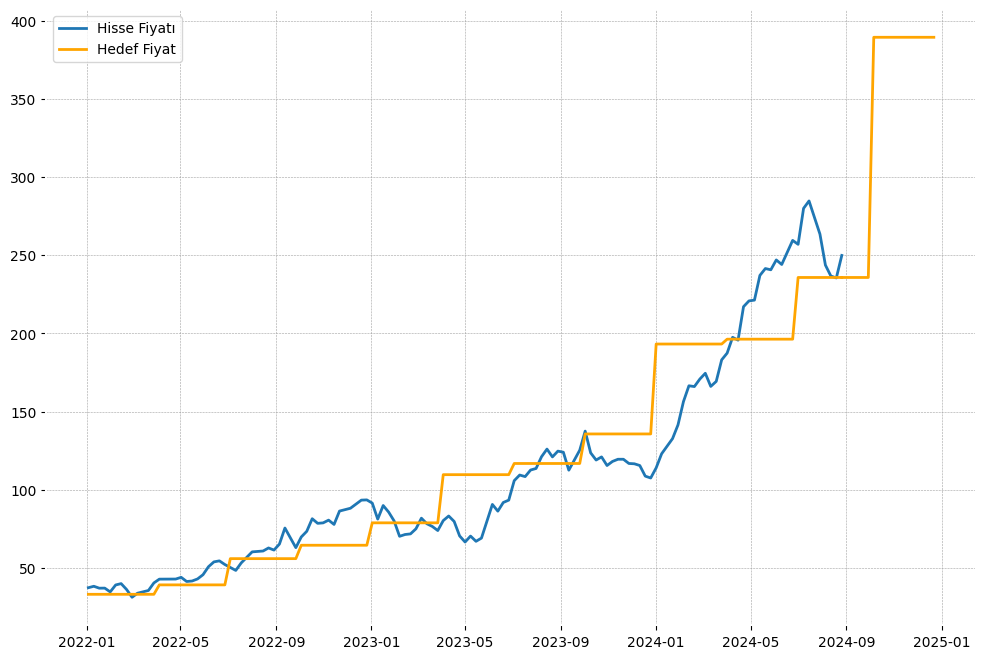

In [1104]:
plt.figure(figsize=(12,8))
plt.plot(hisse["Close"],label="Hisse Fiyatı")
plt.plot(hisse["Hedef"],label="Hedef Fiyat",color="orange")
plt.plot(yeni["Hedef"].loc["2024-08-26":],color="orange")
plt.legend()